In [1]:
!pip -q install pandas geopandas shapely pyproj

In [2]:
import pandas as pd
import geopandas as gpd
from IPython.display import display

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

In [3]:
from pathlib import Path

def read_csv_any(path):
    path = Path(path)
    for enc in ("utf-8-sig", "utf-8", "cp949"):
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            pass
    raise ValueError(f"Failed to read {path}")

def peek(df, name):
    print(f"\n=== {name} | shape={df.shape} ===")
    display(df.head(5))
    print("-- dtypes --\n", df.dtypes)
    print("-- nulls --\n", df.isna().sum())

In [4]:
import geopandas as gpd
import os

os.environ["SHAPE_RESTORE_SHX"] = "YES"  
grid_or_fac_gdf = gpd.read_file("data/match_modified.shp")

print(grid_or_fac_gdf.shape)
print(grid_or_fac_gdf.columns.tolist())
print(grid_or_fac_gdf.crs)
grid_or_fac_gdf.head()

(10125, 5)
['CELL_ID', 'CELL_X', 'CELL_Y', 'GID', 'geometry']
EPSG:5179


,CELL_ID,CELL_X,CELL_Y,GID,geometry
0,다사54504050,954625,1940625,다사54ba40ba,"POLYGON ((954500 1940500, 954500 1940750, 9547..."
1,다사54255675,954375,1956875,다사54ab56bb,"POLYGON ((954250 1956750, 954250 1957000, 9545..."
2,다사54255700,954375,1957125,다사54ab57aa,"POLYGON ((954250 1957000, 954250 1957250, 9545..."
3,다사54255725,954375,1957375,다사54ab57ab,"POLYGON ((954250 1957250, 954250 1957500, 9545..."
4,다사54255750,954375,1957625,다사54ab57ba,"POLYGON ((954250 1957500, 954250 1957750, 9545..."


In [5]:
elder = read_csv_any("data/elder.csv")                 # 현재 65+
future = read_csv_any("data/future.csv")               # 미래 65+
single = read_csv_any("data/single_person.csv")        # 독거노인
income = read_csv_any("data/income.csv")               # 소득/취약지표
fac_tbl = read_csv_any("data/서울시_노인여가복지시설목록_격자ID.csv")  # 시설 + 격자ID
grid_or_fac_gdf = gpd.read_file("data/match_modified.shp")          # 격자 or 시설 지오메트리

In [6]:
# ===== 시설 데이터 정제 (교실 제거 + 중복 제거) =====

# 1) '교실'이 포함된 행 제거
fac_tbl = fac_tbl[~fac_tbl['시설명'].str.contains('교실', na=False)]

# 2) 중복 제거 (시설명 + 격자ID 기준)
fac_tbl = fac_tbl.drop_duplicates(subset=['시설명', '격자ID'])

# 3) 격자ID를 grid_id로 이름 통일 (이후 단계 호환용)
fac_tbl = fac_tbl.rename(columns={'격자ID': 'grid_id'})

# 결과 확인
print("정제 후 시설 수:", len(fac_tbl))
fac_tbl.head()

정제 후 시설 수: 179


,시설명,시설종류명(시설유형),자치구(시)구분,시군구코드,시군구명,시설주소,시설 주소_cleaned,x,y,lat,lng,grid_id
0,성북구립 상월곡실버복지센터,(노인복지시설) 노인복지관(소규모),자치구,1129000000,성북구,서울특별시 성북구 화랑로18길 6 (상월곡동),서울특별시 성북구 화랑로18길 6,960102.534396,1.956362e+06,37.605815,127.047983,다사60005625
1,서초구립양재노인종합복지관,(노인복지시설) 노인복지관,자치구,1165000000,서초구,서울특별시 서초구 강남대로30길,서울특별시 서초구 강남대로30길,959299.944086,1.942672e+06,37.482392,127.039650,다사59254250
2,강서구립봉제산노인복지센터,(노인복지시설) 노인복지관,자치구,1150000000,강서구,서울특별시 강서구 화곡동 산 41-16,서울특별시 강서구 화곡동 산 41-16,942692.924571,1.949340e+06,37.541608,126.851301,다사42504925
3,시립중랑노인종합복지관,(노인복지시설) 노인복지관,자치구,1126000000,중랑구,서울특별시 중랑구 겸재로9길 45 (면목동),서울특별시 중랑구 겸재로9길 45,962735.049850,1.954422e+06,37.588441,127.077906,다사62505425
4,강남구립 강남노인종합복지관,(노인복지시설) 노인복지관,자치구,1168000000,강남구,서울특별시 강남구 삼성로 66 번지,서울특별시 강남구 삼성로 66,961081.969021,1.944853e+06,37.502124,127.059690,다사61004475


In [7]:
import pandas as pd
import geopandas as gpd
from sklearn.preprocessing import MinMaxScaler

def normalize_cols(df):
    df.columns = (df.columns
                    .str.strip()
                    .str.replace("\n"," ", regex=False)
                    .str.replace(r"\s+","_", regex=True)
                    .str.lower())
    return df

for d in (elder, future, single, income, fac_tbl):
    normalize_cols(d)
normalize_cols(grid_or_fac_gdf)

def find_grid_col(cols):
    cands = [c for c in cols if any(k in c for k in ["grid_id","gridid","grid","격자","gid"])]
    return cands[0] if cands else None

grid_col_elder  = find_grid_col(elder.columns)
grid_col_future = find_grid_col(future.columns)
grid_col_single = find_grid_col(single.columns)
grid_col_income = find_grid_col(income.columns)
grid_col_fac    = find_grid_col(fac_tbl.columns)
grid_col_gdf    = find_grid_col(grid_or_fac_gdf.columns)

rename_map = {}
if grid_col_elder and grid_col_elder!="grid_id":   elder.rename(columns={grid_col_elder:"grid_id"}, inplace=True)
if grid_col_future and grid_col_future!="grid_id": future.rename(columns={grid_col_future:"grid_id"}, inplace=True)
if grid_col_single and grid_col_single!="grid_id": single.rename(columns={grid_col_single:"grid_id"}, inplace=True)
if grid_col_income and grid_col_income!="grid_id": income.rename(columns={grid_col_income:"grid_id"}, inplace=True)
if grid_col_fac and grid_col_fac!="grid_id":       fac_tbl.rename(columns={grid_col_fac:"grid_id"}, inplace=True)
if grid_col_gdf and grid_col_gdf!="grid_id":       grid_or_fac_gdf.rename(columns={grid_col_gdf:"grid_id"}, inplace=True)

print("✔ columns unified. samples:")
display(elder.head(2)); display(future.head(2)); display(single.head(2)); display(income.head(2)); display(fac_tbl.head(2)); display(grid_or_fac_gdf.head(2))

✔ columns unified. samples:


,gu,all_sum,elder_sum
0,종로구,149608,29840
1,중구,131214,26853


,gu,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042
0,종로구,144162,142309,140699,139265,137998,136848,135836,134938,134136,133410,132763,132151,131557,130948,130320,129636,128900,128099
1,중구,126858,126445,125889,125199,124405,123727,123133,122609,122120,121642,121196,120766,120300,119817,119278,118702,118067,117367


,gu,single_sum,singleincome_sum,gensingle_sum
0,종로구,9076,371,6342
1,중구,8088,173,5153


,gu,income_sum
0,종로구,2589
1,중구,3205


,시설명,시설종류명(시설유형),자치구(시)구분,시군구코드,시군구명,시설주소,시설_주소_cleaned,x,y,lat,lng,grid_id
0,성북구립 상월곡실버복지센터,(노인복지시설) 노인복지관(소규모),자치구,1129000000,성북구,서울특별시 성북구 화랑로18길 6 (상월곡동),서울특별시 성북구 화랑로18길 6,960102.534396,1.956362e+06,37.605815,127.047983,다사60005625
1,서초구립양재노인종합복지관,(노인복지시설) 노인복지관,자치구,1165000000,서초구,서울특별시 서초구 강남대로30길,서울특별시 서초구 강남대로30길,959299.944086,1.942672e+06,37.482392,127.039650,다사59254250


,cell_id,cell_x,cell_y,grid_id,geometry
0,다사54504050,954625,1940625,다사54ba40ba,"POLYGON ((954500 1940500, 954500 1940750, 9547..."
1,다사54255675,954375,1956875,다사54ab56bb,"POLYGON ((954250 1956750, 954250 1957000, 9545..."


In [8]:
# 데이터프레임 이름과 컬럼명을 같이 출력
print("elder columns:", elder.columns.tolist())
print("future columns:", future.columns.tolist())
print("single columns:", single.columns.tolist())
print("income columns:", income.columns.tolist())
print("fac_tbl columns:", fac_tbl.columns.tolist())
print("grid_or_fac_gdf columns:", grid_or_fac_gdf.columns.tolist())

elder columns: ['gu', 'all_sum', 'elder_sum']
future columns: ['gu', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033', '2034', '2035', '2036', '2037', '2038', '2039', '2040', '2041', '2042']
single columns: ['gu', 'single_sum', 'singleincome_sum', 'gensingle_sum']
income columns: ['gu', 'income_sum']
fac_tbl columns: ['시설명', '시설종류명(시설유형)', '자치구(시)구분', '시군구코드', '시군구명', '시설주소', '시설_주소_cleaned', 'x', 'y', 'lat', 'lng', 'grid_id']
grid_or_fac_gdf columns: ['cell_id', 'cell_x', 'cell_y', 'grid_id', 'geometry']


In [9]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 1) 필요한 컬럼만 추출 & 이름 통일
elder_gu  = elder[['gu', 'elder_sum']].copy()
single_gu = single[['gu', 'single_sum']].copy()
income_gu = income[['gu', 'income_sum']].copy()

# 미래연도 선택 (예: 2035년)
target_year = '2035'
future_gu = future[['gu', target_year]].copy().rename(columns={target_year: 'future_elder_sum'})

# 2) 병합 (gu 키)
df_gu = (elder_gu
         .merge(future_gu, on='gu', how='outer')
         .merge(single_gu, on='gu', how='outer')
         .merge(income_gu, on='gu', how='outer'))

# 결측치 0 채움
df_gu = df_gu.fillna(0)

# 3) Min-Max 표준화
scaler = MinMaxScaler()
for col in ['elder_sum','future_elder_sum','single_sum','income_sum']:
    df_gu[f'{col}_mm'] = scaler.fit_transform(df_gu[[col]])

# 4) 가중합으로 수요지수 D (가중치는 예시값)
w = dict(elder=0.35, future=0.30, single=0.25, income=0.10)
df_gu['D'] = (w['elder']  * df_gu['elder_sum_mm'] +
              w['future'] * df_gu['future_elder_sum_mm'] +
              w['single'] * df_gu['single_sum_mm'] +
              w['income'] * df_gu['income_sum_mm'])

print("✔ D_by_gu ready:", df_gu.shape)
df_gu.head()

✔ D_by_gu ready: (26, 10)


,gu,elder_sum,future_elder_sum,single_sum,income_sum,elder_sum_mm,future_elder_sum_mm,single_sum_mm,income_sum_mm,D
0,강남구,91470.0,545428.0,23747.0,7047.0,0.800662,0.899177,0.585608,0.469112,0.743298
1,강동구,89895.0,498480.0,22874.0,7389.0,0.786875,0.821780,0.564080,0.491879,0.712148
2,강북구,71411.0,250625.0,21570.0,10460.0,0.625080,0.413173,0.531923,0.696312,0.545342
3,강서구,107553.0,513567.0,40551.0,15022.0,0.941441,0.846652,1.000000,1.000000,0.933500
4,관악구,88885.0,444130.0,24154.0,9786.0,0.778035,0.732180,0.595645,0.651445,0.706022


In [10]:
import geopandas as gpd
from pathlib import Path

def find_gu_boundary(root="data"):
    root = Path(root)
    cand = list(root.glob("**/*.shp")) + list(root.glob("**/*.geojson"))
    gu_name_keys = {'gu','sigungu','sigungu_nm','adm_nm','name','sig_kor_nm','시군구명','자치구','구'}

    for p in cand:
        try:
            gdf = gpd.read_file(p)
        except Exception:
            continue
        # 폴리곤 계열만 후보
        if not any(t.lower().startswith(("poly","multi")) for t in gdf.geom_type.astype(str).str.lower().unique()):
            continue
        cols_lc = [c.lower() for c in gdf.columns]
        # 자치구 이름 컬럼 탐색
        name_col = None
        for c in gdf.columns:
            if c.lower() in gu_name_keys:
                name_col = c
                break
        if name_col is None:
            # 부분 일치도 허용
            for c in gdf.columns:
                lc = c.lower()
                if any(k in lc for k in ['gu','sigungu','adm','시군구','자치구','구']):
                    name_col = c
                    break
        if name_col is None:
            continue

        return p, gdf, name_col  # 적합한 레이어 발견
    return None, None, None

path, gu_boundary, gu_name_col = find_gu_boundary("data")
print("찾은 경계 파일:", path)
print("자치구 이름 컬럼:", gu_name_col)
if gu_boundary is not None:
    display(gu_boundary.head())

찾은 경계 파일: data/서울시_행정동경계_only.geojson
자치구 이름 컬럼: adm_nm


,adm_nm,adm_cd2,sgg,sido,sidonm,sggnm,adm_cd,geometry
0,서울특별시 종로구 사직동,1111053000,11110,11,서울특별시,종로구,11010530,"MULTIPOLYGON (((126.97689 37.57565, 126.97703 ..."
1,서울특별시 종로구 삼청동,1111054000,11110,11,서울특별시,종로구,11010540,"MULTIPOLYGON (((126.98269 37.59507, 126.98337 ..."
2,서울특별시 종로구 부암동,1111055000,11110,11,서울특별시,종로구,11010550,"MULTIPOLYGON (((126.97585 37.59656, 126.97359 ..."
3,서울특별시 종로구 평창동,1111056000,11110,11,서울특별시,종로구,11010560,"MULTIPOLYGON (((126.97507 37.63139, 126.97649 ..."
4,서울특별시 종로구 무악동,1111057000,11110,11,서울특별시,종로구,11010570,"MULTIPOLYGON (((126.96067 37.5808, 126.96281 3..."


In [11]:
import geopandas as gpd
import pandas as pd

# 1) 행정동 경계 파일 경로 (네가 넣은 파일명 그대로)
gu_path = "data/서울시_행정동경계_only.geojson"  # ← 파일명 다르면 여기만 바꾸면 됨

# 2) 로드
gu_boundary = gpd.read_file(gu_path)

# 3) 자치구 이름 컬럼 잡기 (우선 'sggnm', 없으면 adm_nm에서 '종로구' 형태 추출)
gu_boundary.columns = [c.lower() for c in gu_boundary.columns]
if "sggnm" in gu_boundary.columns:
    gu_name_col = "sggnm"
else:
    # adm_nm 예시: "서울특별시 종로구 사직동" → 가운데 토큰이 자치구명
    if "adm_nm" not in gu_boundary.columns:
        raise ValueError("경계 파일에 'sggnm' 또는 'adm_nm' 컬럼이 없습니다.")
    gu_boundary["sggnm"] = gu_boundary["adm_nm"].str.split().str[1]
    gu_name_col = "sggnm"

print("자치구 이름 컬럼:", gu_name_col)

# 4) 좌표계 5179로 통일 (격자도 같이)
gdf = grid_or_fac_gdf.copy()
if gdf.crs is None:
    print("⚠️ grid_or_fac_gdf의 CRS가 None입니다. 올바른 CRS를 지정해주세요(예: EPSG:5179).")
else:
    if gdf.crs.to_epsg() != 5179:
        gdf = gdf.to_crs(5179)

if gu_boundary.crs is None:
    # 네 파일은 CRS84(경위도)라고 했으니 EPSG:4326로 가정 후 5179로 변환
    gu_boundary = gu_boundary.set_crs(4326)
if gu_boundary.crs.to_epsg() != 5179:
    gu_boundary = gu_boundary.to_crs(5179)

# 5) 격자 중심점 → 자치구 폴리곤 공간조인으로 grid_id → gu 매핑
gdf["centroid"] = gdf.geometry.centroid
cent = gpd.GeoDataFrame(gdf[["grid_id","centroid"]], geometry="centroid", crs=gdf.crs)

cent2 = gpd.sjoin(
    cent, 
    gu_boundary[[gu_name_col, "geometry"]],
    how="left", 
    predicate="within"
).rename(columns={gu_name_col: "gu"})[["grid_id","gu"]]

# 6) 자치구별 D(df_gu) 붙이기 (이전 STEP2A에서 만든 df_gu 사용)
gdf = gdf.merge(cent2, on="grid_id", how="left") \
         .merge(df_gu[["gu","D"]], on="gu", how="left")

print("✔ grid with GU & D:", gdf.shape)
gdf[["grid_id","gu","D"]].head(10)

자치구 이름 컬럼: sggnm
✔ grid with GU & D: (10125, 8)


,grid_id,gu,D
0,다사54ba40ba,관악구,0.706022
1,다사54ab56bb,종로구,0.230269
2,다사54ab57aa,종로구,0.230269
3,다사54ab57ab,종로구,0.230269
4,다사54ab57ba,성북구,0.677261
5,다사54ab55bb,종로구,0.230269
6,다사54ab56aa,종로구,0.230269
7,다사54ab56ab,종로구,0.230269
8,다사54ab56ba,종로구,0.230269
9,다사54ab58bb,성북구,0.677261


In [12]:
import geopandas as gpd
import pandas as pd
import numpy as np

# gdf : 이전 단계에서 D(수요지수)가 붙은 격자 GeoDataFrame (EPSG:5179)

# 1) 시설 위치 생성
fac = fac_tbl.copy()

# staff-like 컬럼 자동 감지 (있으면 capacity로 사용)
staff_candidates = [c for c in fac.columns if any(k in c.lower() for k in ["staff","종사","인력","직원","인원","capacity","정원"])]
staff_col = staff_candidates[0] if staff_candidates else None

if {"lat","lng"}.issubset(set(fac.columns)):
    fac_gdf = gpd.GeoDataFrame(
        fac,
        geometry=gpd.points_from_xy(fac["lng"], fac["lat"], crs=4326)
    ).to_crs(5179)
else:
    # lat/lng가 없으면 grid_id의 격자 중심점으로 대체
    gdf["centroid"] = gdf.geometry.centroid
    fac_gdf = fac.merge(gdf[["grid_id","centroid"]], on="grid_id", how="left")
    fac_gdf = gpd.GeoDataFrame(fac_gdf, geometry="centroid", crs=gdf.crs).rename_geometry("geometry")

# 2) capacity 정의
if staff_col:
    fac_gdf["staff_cnt"] = pd.to_numeric(fac_gdf[staff_col], errors="coerce").fillna(0)
    alpha = 30  # 종사자 1인당 처리능력(예시)
    fac_gdf["capacity"] = fac_gdf["staff_cnt"] * alpha
else:
    # 종사자 정보가 없으면 시설 1개 = 1 용량으로 설정
    fac_gdf["capacity"] = 1.0

print("fac_gdf:", fac_gdf.shape, "| columns:", fac_gdf.columns.tolist()[:10])
fac_gdf.head(2)

fac_gdf: (179, 14) | columns: ['시설명', '시설종류명(시설유형)', '자치구(시)구분', '시군구코드', '시군구명', '시설주소', '시설_주소_cleaned', 'x', 'y', 'lat']


,시설명,시설종류명(시설유형),자치구(시)구분,시군구코드,시군구명,시설주소,시설_주소_cleaned,x,y,lat,lng,grid_id,geometry,capacity
0,성북구립 상월곡실버복지센터,(노인복지시설) 노인복지관(소규모),자치구,1129000000,성북구,서울특별시 성북구 화랑로18길 6 (상월곡동),서울특별시 성북구 화랑로18길 6,960102.534396,1.956362e+06,37.605815,127.047983,다사60005625,POINT (960102.534 1956361.872),1.0
1,서초구립양재노인종합복지관,(노인복지시설) 노인복지관,자치구,1165000000,서초구,서울특별시 서초구 강남대로30길,서울특별시 서초구 강남대로30길,959299.944086,1.942672e+06,37.482392,127.039650,다사59254250,POINT (959299.944 1942672.332),1.0


In [13]:
import geopandas as gpd
import pandas as pd
import numpy as np

fac = fac_tbl.copy()

# 1) lat/lng 숫자형 변환
for c in ["lat","lng"]:
    if c in fac.columns:
        fac[c] = pd.to_numeric(fac[c], errors="coerce")

print("lat/lng nulls:", fac["lat"].isna().sum() if "lat" in fac.columns else "no lat",
      fac["lng"].isna().sum() if "lng" in fac.columns else "no lng")

# 2) geometry 만들기 (있으면 lat/lng, 없으면 grid_id 중심점)
if {"lat","lng"}.issubset(fac.columns) and fac["lat"].notna().any() and fac["lng"].notna().any():
    fac_gdf = gpd.GeoDataFrame(
        fac.dropna(subset=["lat","lng"]).copy(),
        geometry=gpd.points_from_xy(fac["lng"], fac["lat"], crs=4326)  # WGS84
    )
else:
    # grid_id 기준으로 격자 중심 사용
    # gdf는 폴리곤, CRS는 5179로 맞춰져 있어야 함
    cent4fac = gpd.GeoDataFrame(
        gdf[["grid_id"]].copy(),
        geometry=gdf.geometry.centroid,
        crs=gdf.crs
    )
    fac_gdf = fac.merge(cent4fac, on="grid_id", how="left")
    fac_gdf = gpd.GeoDataFrame(fac_gdf, geometry="geometry", crs=gdf.crs)

# 3) fac_gdf를 gdf와 동일 CRS(=5179)로 변환
if fac_gdf.crs is None:
    # lat/lng를 쓴 경우 위에서 4326으로 지정했음. 혹시 None이면 지정 후 변환
    fac_gdf = fac_gdf.set_crs(4326, allow_override=True)

fac_gdf = fac_gdf.to_crs(gdf.crs)   # gdf는 앞에서 5179로 맞췄음

# 4) capacity (종사자 컬럼이 없으면 1로)
staff_candidates = [c for c in fac_gdf.columns if any(k in c.lower() for k in ["staff","종사","인력","직원","인원","capacity","정원"])]
if staff_candidates:
    sc = staff_candidates[0]
    fac_gdf["staff_cnt"] = pd.to_numeric(fac_gdf[sc], errors="coerce").fillna(0)
    alpha = 30
    fac_gdf["capacity"] = fac_gdf["staff_cnt"] * alpha
else:
    fac_gdf["capacity"] = 1.0

print("fac_gdf crs:", fac_gdf.crs)
print("fac_gdf rows:", len(fac_gdf), " | non-null geometry:", fac_gdf.geometry.notna().sum())
fac_gdf.head(2)

lat/lng nulls: 0 0
fac_gdf crs: EPSG:5179
fac_gdf rows: 179  | non-null geometry: 179


,시설명,시설종류명(시설유형),자치구(시)구분,시군구코드,시군구명,시설주소,시설_주소_cleaned,x,y,lat,lng,grid_id,geometry,capacity
0,성북구립 상월곡실버복지센터,(노인복지시설) 노인복지관(소규모),자치구,1129000000,성북구,서울특별시 성북구 화랑로18길 6 (상월곡동),서울특별시 성북구 화랑로18길 6,960102.534396,1.956362e+06,37.605815,127.047983,다사60005625,POINT (960102.534 1956361.872),1.0
1,서초구립양재노인종합복지관,(노인복지시설) 노인복지관,자치구,1165000000,서초구,서울특별시 서초구 강남대로30길,서울특별시 서초구 강남대로30길,959299.944086,1.942672e+06,37.482392,127.039650,다사59254250,POINT (959299.944 1942672.332),1.0


In [14]:
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd

# 격자 중심
cent = gpd.GeoDataFrame(
    gdf[["grid_id","D"]].copy(),
    geometry=gdf.geometry.centroid,
    crs=gdf.crs
)

# 버퍼
R = 1500  # 일단 1.5km로 키워서 히트 여부 먼저 확인
buf = cent.copy()
buf = buf.set_geometry(buf.geometry.buffer(R))

# 조인: 시설이 버퍼 안에 있으면 hit
joined = gpd.sjoin(
    fac_gdf[["capacity","geometry"]],
    buf[["grid_id","geometry"]],
    how="right",
    predicate="within"
)

print("sjoin rows:", len(joined))
print("hits (시설 있는 버퍼 수):", (joined["capacity"]>0).sum())

S = joined.groupby("grid_id")["capacity"].sum().rename("S").fillna(0)

gdf = gdf.drop(columns=["S","S_norm","M"], errors="ignore").merge(S, on="grid_id", how="left")
gdf["S"] = gdf["S"].fillna(0)
gdf["S_norm"] = MinMaxScaler().fit_transform(gdf[["S"]])
gdf["M"] = gdf["D"] - gdf["S_norm"]

gdf[["grid_id","gu","D","S","S_norm","M"]].head()

sjoin rows: 22538
hits (시설 있는 버퍼 수): 19742


,grid_id,gu,D,S,S_norm,M
0,다사54ba40ba,관악구,0.706022,1.0,0.090909,0.615113
1,다사54ab56bb,종로구,0.230269,0.0,0.000000,0.230269
2,다사54ab57aa,종로구,0.230269,0.0,0.000000,0.230269
3,다사54ab57ab,종로구,0.230269,0.0,0.000000,0.230269
4,다사54ab57ba,성북구,0.677261,0.0,0.000000,0.677261


In [15]:
import numpy as np

# 기존 시설이 있는 grid_id
grids_with_fac = set(fac_gdf['grid_id'].dropna())

# M 상위 15% 임계값
q = gdf['M'].quantile(0.85)
candidates = gdf[(gdf['M'] >= q) & (~gdf['grid_id'].isin(grids_with_fac))].copy()

print("후보 격자 수:", len(candidates), "| 임계값 M >=", round(q, 4))
candidates = candidates[['grid_id','gu','D','M','geometry']].reset_index(drop=True)
candidates.head()

후보 격자 수: 1458 | 임계값 M >= 0.7063


,grid_id,gu,D,M,geometry
0,다사53aa59aa,은평구,0.741541,0.741541,"POLYGON ((953000 1959000, 953000 1959250, 9532..."
1,다사71bb49bb,강동구,0.712148,0.712148,"POLYGON ((971750 1949750, 971750 1950000, 9720..."
2,다사71bb50aa,강동구,0.712148,0.712148,"POLYGON ((971750 1950000, 971750 1950250, 9720..."
3,다사71aa49bb,강동구,0.712148,0.712148,"POLYGON ((971000 1949750, 971000 1950000, 9712..."
4,다사71aa50aa,강동구,0.712148,0.712148,"POLYGON ((971000 1950000, 971000 1950250, 9712..."


In [16]:
pip install ortools

Note: you may need to restart the kernel to use updated packages.


In [17]:
import numpy as np
from ortools.linear_solver import pywraplp
import geopandas as gpd

R_cover = 1000   # 커버 반경(1km)
p = 10           # 설치 개수(원하는 숫자로 변경)

# 1) 커버 행렬 A[i,j] (수요격자 i가 후보지 j 반경 내면 1)
demand_pts = gpd.GeoDataFrame(
    gdf[['grid_id','D']].copy(),
    geometry=gdf.geometry.centroid, crs=gdf.crs
)
cand_pts = gpd.GeoDataFrame(
    candidates[['grid_id']].copy().rename(columns={'grid_id':'cand_id'}),
    geometry=candidates.geometry.centroid, crs=gdf.crs
)

# 거리 계산 (벡터화 간단 버전)
A = np.zeros((len(demand_pts), len(cand_pts)), dtype=np.int8)
for j, gj in enumerate(cand_pts.geometry):
    A[:, j] = demand_pts.geometry.distance(gj).values <= R_cover

D_vec = demand_pts['D'].values  # 수요 가중치

# 2) OR-Tools 모델
solver = pywraplp.Solver.CreateSolver('SCIP')
y = [solver.BoolVar(f'y_{j}') for j in range(A.shape[1])]     # 후보지 선택
z = [solver.BoolVar(f'z_{i}') for i in range(A.shape[0])]     # 격자 커버 여부

# 커버 제약: 격자 i는 적어도 하나의 선택된 후보지 반경 내에 있어야 커버됨
for i in range(A.shape[0]):
    solver.Add(z[i] <= sum(A[i, j]*y[j] for j in range(A.shape[1])))

# 예산 제약: p개 선택
solver.Add(sum(y) == p)

# 목적함수: 커버된 수요 D 합 최대화
solver.Maximize(solver.Sum(D_vec[i]*z[i] for i in range(A.shape[0])))

# 최적화 실행
status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print("✅ Optimal solution found!")
elif status == pywraplp.Solver.FEASIBLE:
    print("⚠️ Feasible but not optimal.")
else:
    print("❌ No solution found.")

selected_idx = [j for j in range(len(y)) if y[j].solution_value() > 0.5]
selected = cand_pts.iloc[selected_idx].copy()
print("선정된 후보 수:", len(selected_idx))
selected.head()

✅ Optimal solution found!
선정된 후보 수: 10


,cand_id,geometry
162,다사67aa44ba,POINT (967125 1944625)
363,다사65ab45ab,POINT (965375 1945375)
811,다사43bb50ba,POINT (943875 1950625)
826,다사42aa52aa,POINT (942125 1952125)
880,다사40bb50ab,POINT (940875 1950375)


In [19]:
pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.8/18.8 MB 59.6 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9/9 [contextily]9 [rasterio]
Note: you may need to restart the kernel to use updated packages.


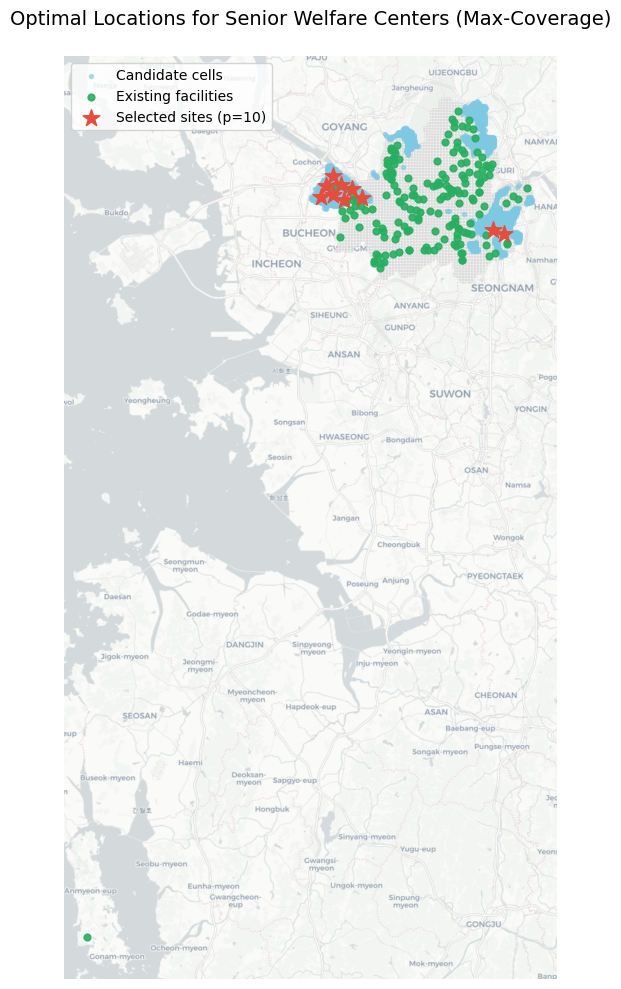

In [20]:
# === Pretty map plot on a basemap (CartoDB Positron) ===
import geopandas as gpd
import matplotlib.pyplot as plt

try:
    import contextily as cx
except ImportError:
    raise ImportError("contextily가 필요합니다. pip install contextily 로 설치하세요.")

# 1) 폴리곤은 연한 배경, 점은 중심점으로 변환
gdf_poly = gdf.copy()
gdf_pts  = gpd.GeoDataFrame(gdf[['grid_id','D','M']].copy(),
                            geometry=gdf.geometry.centroid, crs=gdf.crs)
cand_pts = gpd.GeoDataFrame(candidates[['grid_id','M']].copy(),
                            geometry=candidates.geometry.centroid, crs=gdf.crs)
sel_pts  = selected.copy()  # cand_pts에서 뽑았으니 이미 포인트
fac_pts  = fac_gdf.copy()   # 기존 시설(포인트)

# 2) Web Mercator(EPSG:3857)로 변환 (웹지도 좌표)
to3857 = lambda x: x.to_crs(3857)
gdf_poly_3857 = to3857(gdf_poly)
gdf_pts_3857  = to3857(gdf_pts)
cand_3857     = to3857(cand_pts)
sel_3857      = to3857(sel_pts)
fac_3857      = to3857(fac_pts)

# 3) 플롯
fig, ax = plt.subplots(figsize=(10,10))

# 배경 폴리곤 연하게
gdf_poly_3857.plot(ax=ax, facecolor="#f6f6f6", edgecolor="#cfcfcf", linewidth=0.2)

# 후보지(연한 파랑), 기존 시설(초록), 선정(빨간 별)
cand_3857.plot(ax=ax, markersize=8, color="#7ec8e3", alpha=0.6, label="Candidate cells")
fac_3857.plot(ax=ax, markersize=24, color="#27ae60", alpha=0.9, label="Existing facilities")
if len(sel_3857):
    sel_3857.plot(ax=ax, marker='*', markersize=160, color="#e74c3c", label=f"Selected sites (p={len(sel_3857)})")

# 베이스맵
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, attribution=False)

ax.set_title("Optimal Locations for Senior Welfare Centers (Max-Coverage)", fontsize=14, pad=12)
ax.set_axis_off()
ax.legend(loc="upper left", frameon=True)
plt.tight_layout()
plt.show()

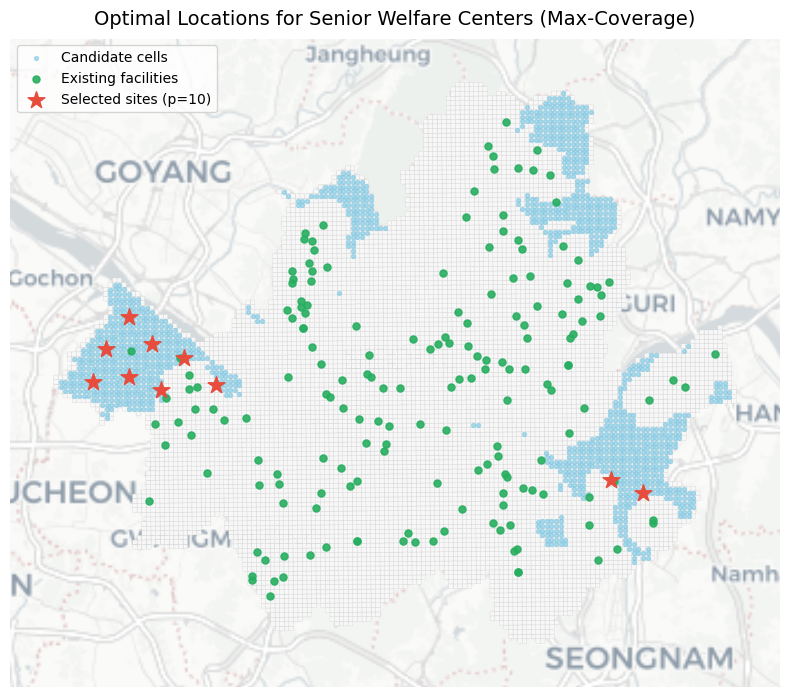

In [22]:
# Zoomed, pretty basemap around Seoul only
import geopandas as gpd
import matplotlib.pyplot as plt

try:
    import contextily as cx
except ImportError:
    raise ImportError("contextily가 필요합니다.  pip install contextily")

# 1) 포인트화 + 3857로 변환
gdf_poly = gdf.copy()
gdf_pts  = gpd.GeoDataFrame(gdf[['grid_id','D','M']].copy(),
                            geometry=gdf.geometry.centroid, crs=gdf.crs)
cand_pts = gpd.GeoDataFrame(candidates[['grid_id','M']].copy(),
                            geometry=candidates.geometry.centroid, crs=gdf.crs)
sel_pts  = selected.copy()
fac_pts  = fac_gdf.copy()

to3857 = lambda x: x.to_crs(3857)
gdf_poly_3857 = to3857(gdf_poly)
cand_3857     = to3857(cand_pts)
sel_3857      = to3857(sel_pts)
fac_3857      = to3857(fac_pts)

# 2) 서울 범위(= 격자 전체 bounds)에 여백(m) 주기
minx, miny, maxx, maxy = gdf_poly_3857.total_bounds
pad = 3000  # 3km 여백 (필요시 2000~5000 조절)
xlim = (minx - pad, maxx + pad)
ylim = (miny - pad, maxy + pad)

# 3) 플롯
fig, ax = plt.subplots(figsize=(8,8))

# 후보지(연파랑), 기존 시설(초록), 선정(빨간 별)
gdf_poly_3857.plot(ax=ax, facecolor="#f7f7f7", edgecolor="#cdcdcd", linewidth=0.2)
cand_3857.plot(ax=ax, markersize=8, color="#7ec8e3", alpha=0.6, label="Candidate cells")
fac_3857.plot(ax=ax, markersize=26, color="#27ae60", alpha=0.9, label="Existing facilities")
if len(sel_3857):
    sel_3857.plot(ax=ax, marker='*', markersize=160, color="#e74c3c", label=f"Selected sites (p={len(sel_3857)})")

# 베이스맵 (CartoDB.Positron 권장)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, attribution=False)

# 서울만 보이게 범위 제한
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

ax.set_title("Optimal Locations for Senior Welfare Centers (Max-Coverage)", fontsize=14, pad=10)
ax.set_axis_off()
ax.legend(loc="upper left", frameon=True)
plt.tight_layout()
plt.show()